<a href="https://colab.research.google.com/github/hypro2/LLM-Multimodal-Colab/blob/main/nomic_embed_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install -q -U transformers peft accelerate optimum
!pip install --quiet bitsandbytes

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

sentences = ['search_query: What is TSNE?', 'search_query: Who is Laurens van der Maaten?']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1', trust_remote_code=True).cuda()
model.eval()

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
encoded_input = {k: v.to('cuda') for k,v in encoded_input.items()}

with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
embeddings = F.normalize(embeddings, p=2, dim=1)

print(embeddings)

tensor([[ 1.0951e-02,  5.7415e-02, -1.1036e-02,  ...,  3.5169e-05,
         -2.8092e-02, -2.1600e-02],
        [-1.3367e-02,  2.7091e-02, -2.3367e-02,  ...,  2.8799e-02,
         -1.0675e-02,  2.8821e-02]], device='cuda:0')


In [3]:
len(embeddings[0])

768

In [5]:
from sklearn.metrics.pairwise import cosine_similarity


distances = cosine_similarity(embeddings.cpu().numpy())
distances

array([[0.99999964, 0.36237895],
       [0.36237895, 1.0000001 ]], dtype=float32)

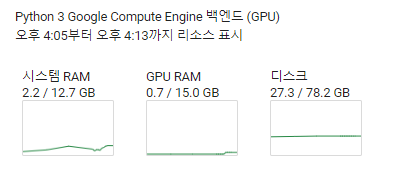